# Graphical Models

*Description: A Markov Random Field (RMF) is an undirected graph model of joint probability distribution that uses undirected edges to represent soft constraints among nodes in the graph. *

The notebook shows how a RMF can be used for image restoration. Specifically, we follow http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0809/ORCHARD/, in which a MATLAB implementation of an Iterated Conditional Modes (ICM) algorithm is presented. Here we implement the ICM algorithm using Python and use it for a simple example.

Algorithm Illustration by Code, supporting course material for Machine Learning, Zheng-Hua Tan, Aalborg University

In [1]:
import numpy as np
from skimage import data, color
import matplotlib.pyplot as plt
import numba

## Load an image 

First let's import an image from the skimage.data package, convert it to greyscale and show it.

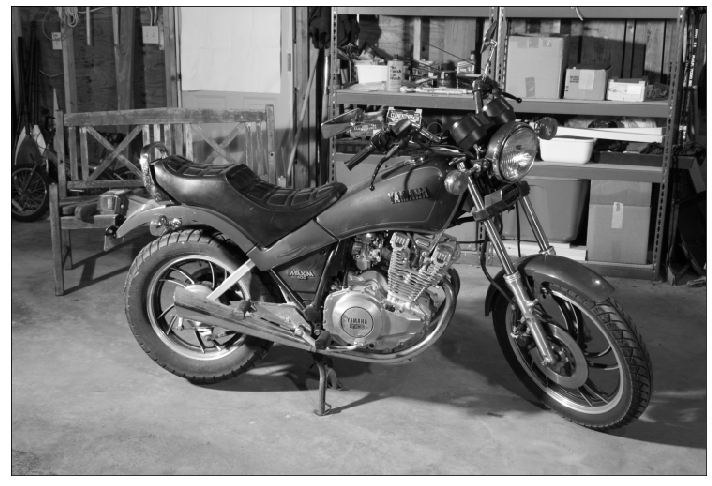

In [2]:
image_rgb = data.stereo_motorcycle()[0]
# We convert to greyscale, by taking a average of the 3 (red (R), green (G) and blue (B)) color channels.
image = np.round(np.mean(image_rgb, axis=2, dtype=np.int16))

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
#plt.imshow(image_rgb)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.show()

## Generate Gaussian noise

As we aim to use a RMF for image restoration, let's corrupt the image with noise first (in order to denoise it later on). We generate an additive noise value for each pixel in the image. The noise is generated according to a zero-mean Gaussian distribution and rounded to integers (as the pixel values are int16).

In [3]:
var = 100

noise = np.asarray(np.round(np.random.normal(loc=0,scale=np.sqrt(var),
                                             size = image.shape)), dtype = np.int16)

## Add the noise to the image 

Then we add to the noise to the original image and limit the values in the range [0, 255].

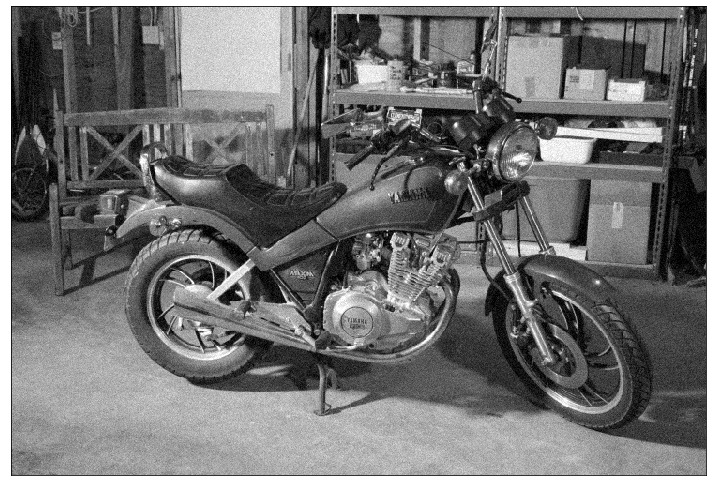

In [4]:
image_noisy = (image + noise)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image_noisy[i, j] > 255:
            image_noisy[i, j] = 255
        elif image_noisy[i, j] < 0:
            image_noisy[i, j] = 0
            
plt.figure(figsize=(10, 10))
plt.imshow(image_noisy, cmap='gray')
#plt.imshow(noise, cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.show()

## Implement the Iterated Conditional Modes algorithm.

In [5]:
# Note that we use the decorator @numba.jit. This is a compiler that speeds up computation
# This is very useful for nested loops that result in long computation time

@numba.jit
def func(_im_noise, _var, _iterations, _w_diff, _max_diff):
    # The ICM algorithm takes the input image and produce a processed image.
    # The processed image then acts as the input image for the following iteration.
    # This is why we create an array with the image inside twice and then we can alternate which one to update.
    image_buffer = np.array((np.copy(_im_noise), np.copy(_im_noise)))
    
    # This value is guaranteed to be larger than any potential of any configuration of pixel values.
    V_max = _im_noise.shape[0] * _im_noise.shape[1] * (256**2) / (2 * _var) + 4 * _w_diff * _max_diff
    
    for n in range(_iterations):
        
        # These variables are for keeping track of indexing in the buffer image. 
        s = n % 2
        d = (n + 1) % 2

        # Now, we loop over all pixel values.
        for i in range(_im_noise.shape[0]):
            for j in range(_im_noise.shape[1]):

                V_local = V_max
                min_val = -1
                
                # The idea is to find the value for each pixel that minimizes the potential
                for k in range(256):
                    
                    # Here we compute the component of the clique potential, if the (i,j)th pixel
                    # is changed to k. See V_n in the provided link.
                    V_data = (k - _im_noise[i, j])**2 / (2 * _var)
                    
                    V_diff = 0
                    
                    # Here we compute the component of the clique potential due to the difference
                    # between neighbouring pixel values. See V_{mn} in the provided link.
                    # The conditional statements are to combat edge effects
                    if i > 0:
                        V_diff += min(((k - image_buffer[s, i - 1, j])**2, _max_diff))
                    if i < _im_noise.shape[0] - 1:
                        V_diff += min(((k - image_buffer[s, i + 1, j])**2, _max_diff))
                    if j > 0:
                        V_diff += min(((k - image_buffer[s, i, j - 1])**2, _max_diff))
                    if j < _im_noise.shape[1] - 1:
                        V_diff += min(((k - image_buffer[s, i, j + 1])**2, _max_diff))
                    
                    # Compute the combined potential
                    V_current = V_data + _w_diff * V_diff
                    
                    # We only update the values if new current potential is lower then the previous.
                    # Remember we are minimizing.
                    if V_current < V_local:
                        min_val = k
                        V_local = V_current
                
                # The buffer image is updated with the value that minimizes that potential.
                image_buffer[d, i, j] = min_val
    
    return image_buffer[d]

## Specify the hyper-parameters 

In order to run the algorithm, a few parameters need to be specified.
- the variance in the clique potential, here let's use to variance that actually corrupted the image as an ideal case.
- the number of iterations that the algorithms iterates over the image.
- the weighting attached to the potential due to the difference between two neighbouring pixel values. ($\gamma$ in the provided link).
- the maximum contribtuion to the potential of the difference between two neighbouring pixel values ($\beta$ in the provided link).

Let's set these parameters and run the algorithm.

In [6]:
iterations = 100
w_diff = 0.015
max_diff = 100

## Run the algorithm

The use of the numba.jit decorator will (maybe) raise an error. It is not ideal to ignore such errors, but we still achieve the desired speed up.

In [7]:
image_recon = func(image_noisy, var, iterations, w_diff, max_diff)

<ipython-input-5-235b9b9cfe59>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "func" failed type inference due to: Invalid use of Function(<built-in function array>) with argument(s) of type(s): (tuple(array(int16, 2d, C) x 2))
 * parameterized
In definition 0:
    TypingError: array(int16, 2d, C) not allowed in a homogeneous sequence
    raised from /Users/zt/opt/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:460
In definition 1:
    TypingError: array(int16, 2d, C) not allowed in a homogeneous sequence
    raised from /Users/zt/opt/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:460
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function array>)
[2] During: typing of call at <ipython-input-5-235b9b9cfe59> (9)


File "<ipython-input-5-235b9b9cfe59>", line 9:
def func(_im_noise, _var, _iterat

## Result 

Let's - by visual inspection - see how the algorithm performed.

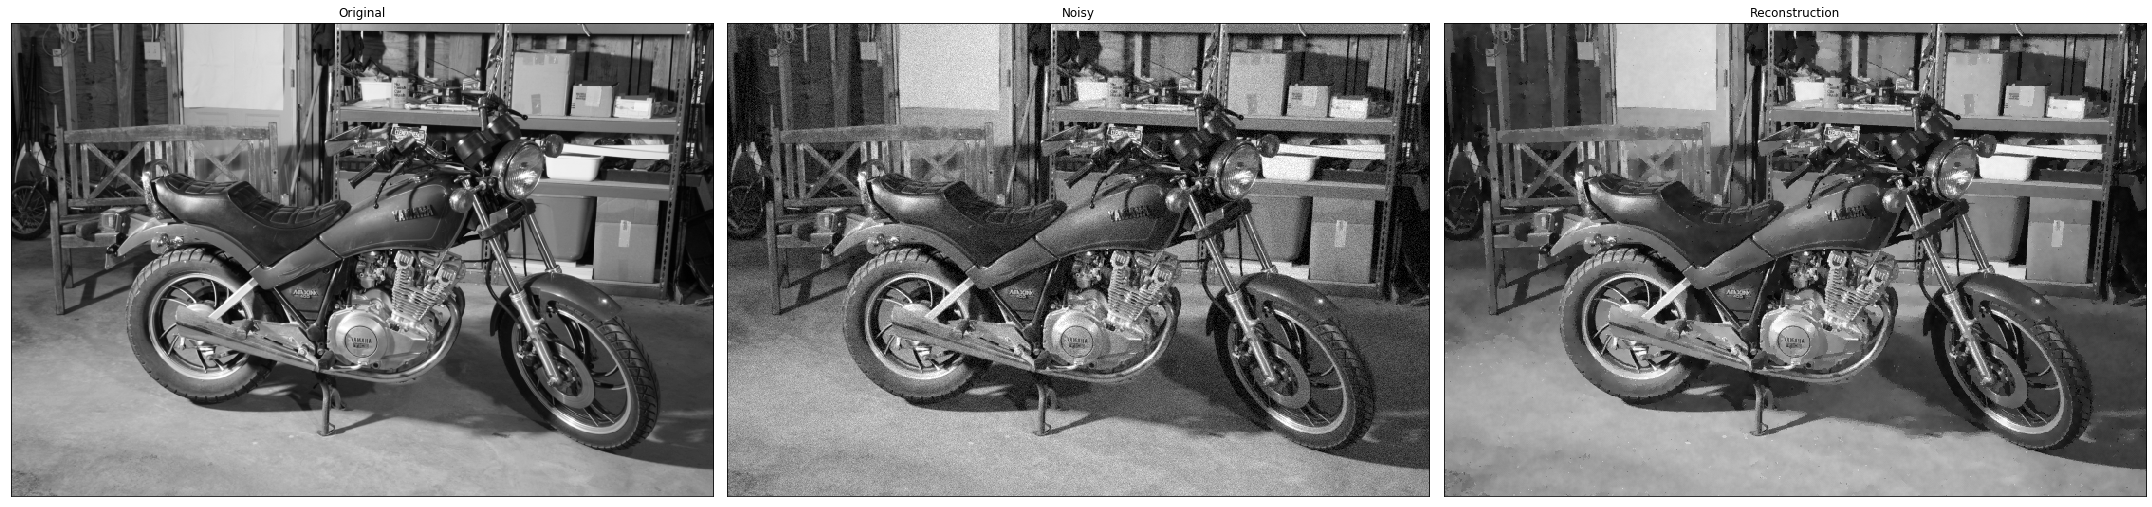

In [8]:
plt.figure(figsize=(30, 10))

plt.subplot(131)

plt.title('Original')
plt.imshow(image, cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

plt.subplot(132)

plt.title('Noisy')
plt.imshow(image_noisy, cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

plt.subplot(133)

plt.title('Reconstruction')
plt.imshow(image_recon, cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

plt.show()

## Discussion

We see that the algorithm has smoothed the noise. Speficially surfaces of slowly-varying intensity, e.g., the sides of the boxes are well-restored. However, areas with rapidly-varying intensities, e.g., motorcycle parts and text, are not are well-reconsored. Try to change the paramters used throughout this notebook, i.e., noise variance, iterations, $\gamma$ and $\beta$ to see if better results can be achieved.